In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model, load_model
import os
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = pd.read_csv('ratings.csv')
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


None

In [5]:
dups = dataset.duplicated()
print(dups.any())

True


In [6]:
print(dataset[dups])

        book_id  user_id  rating
1171         12    40251       4
2474         25    32635       5
2959         30    31760       4
3020         31     8669       5
3334         34    26097       1
...         ...      ...     ...
979373     9975     3133       3
980520     9988      907       4
981044     9993    33994       4
981257     9995    28898       2
981369     9996    48576       5

[1644 rows x 3 columns]


In [7]:
null = dataset.isnull()
print(null.any())
print(dataset.shape)

book_id    False
user_id    False
rating     False
dtype: bool
(981756, 3)


In [8]:
dataset.dropna()
print(dataset.shape)

(981756, 3)


Text(0.5, 1.0, 'User ratings')

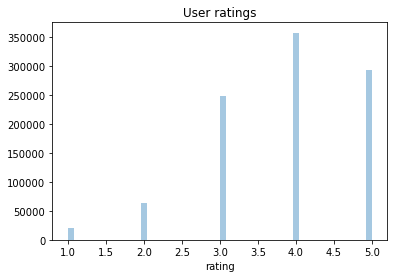

In [9]:
sns.distplot(dataset.rating,kde=False)
plt.title('User ratings')

In [10]:
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [11]:
books.columns

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')

In [12]:
min_books = books[['id','book_id','authors','original_publication_year', 'title', 'average_rating', 'small_image_url']]
min_books.head()

,id,book_id,authors,original_publication_year,title,average_rating,small_image_url
0,1,2767052,Suzanne Collins,2008.0,"The Hunger Games (The Hunger Games, #1)",4.34,https://images.gr-assets.com/books/1447303603s...
1,2,3,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Sorcerer's Stone (Harry P...,4.44,https://images.gr-assets.com/books/1474154022s...
2,3,41865,Stephenie Meyer,2005.0,"Twilight (Twilight, #1)",3.57,https://images.gr-assets.com/books/1361039443s...
3,4,2657,Harper Lee,1960.0,To Kill a Mockingbird,4.25,https://images.gr-assets.com/books/1361975680s...
4,5,4671,F. Scott Fitzgerald,1925.0,The Great Gatsby,3.89,https://images.gr-assets.com/books/1490528560s...


In [13]:
X, y = train_test_split(dataset, test_size=0.2, random_state=42)

In [14]:
display(X.head())
display(y.head())

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3
21471,215,33864,5
272540,2728,16587,3


In [15]:
users = len(dataset.user_id.unique())
users

53424

In [16]:
n_books = len(dataset.book_id.unique())
n_books

10000

In [23]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_flatten = Flatten(name="Flatten-Books")(book_embedding)

In [24]:
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(users+1, 5, name="User-Embedding")(user_input)
user_flatten = Flatten(name="Flatten-Users")(user_embedding)
conc = Concatenate()([book_flatten, user_flatten])

In [25]:
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

In [26]:
model2 = Model([user_input, book_input], out)
model2.compile('adam', 'mean_squared_error')

In [27]:
if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model2.fit([X.user_id, X.book_id], X.rating, epochs=5, verbose=1)
    model2.save('regression_model2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [28]:
model2.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [29]:
model2.evaluate([y.user_id, y.book_id], y.rating)

6136/6136 [==============================] - 5s 690us/step - loss: 0.7086


0.7085840106010437

In [30]:
predictions = model2.predict([y.user_id.head(10), y.book_id.head(10)])
[print(predictions[i], y.rating.iloc[i]) for i in range(0,10)]

[4.9669037] 5
[3.8755074] 4
[3.4574277] 3
[4.0612445] 5
[3.3729417] 3
[4.1597533] 3
[3.497297] 3
[4.854315] 4
[4.0013123] 3
[4.1659794] 5


[None, None, None, None, None, None, None, None, None, None]

In [31]:
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

<AxesSubplot:>

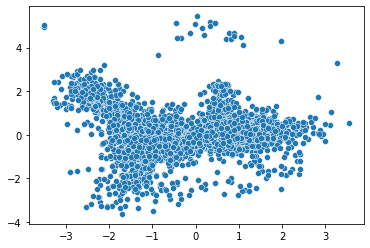

In [32]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(pca_result[:,0], pca_result[:,1])

In [33]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0000001

<AxesSubplot:>

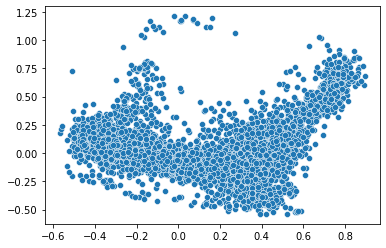

In [34]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(pca_result[:,0], pca_result[:,1])

In [35]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.015s...
[t-SNE] Computed neighbors for 10001 samples in 0.622s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.030048
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.880798
[t-SNE] KL

<AxesSubplot:>

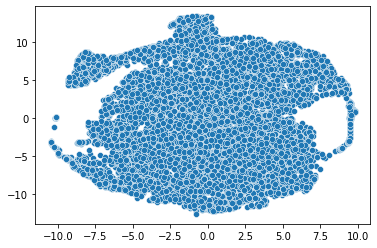

In [36]:
sns.scatterplot(tnse_results[:,0], tnse_results[:,1])

In [37]:
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [38]:
user = np.array([5 for i in range(len(book_data))])
user[:5]

array([5, 5, 5, 5, 5])

In [39]:
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:5]
recommended_book_ids

array([9208, 4742, 9530, 7152, 7498], dtype=int64)

In [40]:
predictions[recommended_book_ids]

array([2.178436 , 2.1575203, 2.1269994, 2.088244 , 2.087979 ],
      dtype=float32)

In [41]:
min_books[min_books['id'].isin(recommended_book_ids)]

,id,book_id,authors,original_publication_year,title,average_rating,small_image_url
4741,4742,19095025,Kylie Scott,2014.0,"Play (Stage Dive, #2)",4.33,https://images.gr-assets.com/books/1393202794s...
7151,7152,625554,Gerald N. Lund,1994.0,"Pillar of Light (The Work and the Glory, #1)",4.28,https://images.gr-assets.com/books/1416338631s...
7497,7498,29923,Jeff Shaara,1991.0,"The Last Full Measure (The Civil War Trilogy, #3)",4.22,https://images.gr-assets.com/books/1331939776s...
9207,9208,22040598,Scott McCloud,2015.0,The Sculptor,4.00,https://images.gr-assets.com/books/1418629570s...
9529,9530,139176,M.C. Beaton,1992.0,"The Quiche of Death (Agatha Raisin, #1)",3.75,https://s.gr-assets.com/assets/nophoto/book/50...


In [42]:
web_book_data = books[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.head()

,book_id,title,image_url,authors
26,1,Harry Potter and the Half-Blood Prince (Harry ...,https://images.gr-assets.com/books/1361039191m...,"J.K. Rowling, Mary GrandPré"
20,2,Harry Potter and the Order of the Phoenix (Har...,https://images.gr-assets.com/books/1387141547m...,"J.K. Rowling, Mary GrandPré"
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,https://images.gr-assets.com/books/1474154022m...,"J.K. Rowling, Mary GrandPré"
17,5,Harry Potter and the Prisoner of Azkaban (Harr...,https://images.gr-assets.com/books/1499277281m...,"J.K. Rowling, Mary GrandPré, Rufus Beck"
23,6,Harry Potter and the Goblet of Fire (Harry Pot...,https://images.gr-assets.com/books/1361482611m...,"J.K. Rowling, Mary GrandPré"


In [43]:
web_book_data.to_json(r'web_book_data.json', orient='records')